# Data over a magnetic dipole

In this notebook, we generate magnetic field data over a spherical target, which we approximate as a point dipole. 

To run the notebook, you will need to have the package `geoana` installed. It is a package that contains analytic functions for common settings in geophysics (If you are curious to see more, you can check out the [docs](https://geoana.readthedocs.io/en/latest/?badge=latest)). You can install the necessary packages by running from the command line or by uncommenting the first cell in the notebook and running it.

```
pip install -r requirements.txt
```

In [3]:
# !pip install -r requirements.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets

from geoana.em.static import MagneticDipoleWholeSpace
from geoana import utils, spatial

%matplotlib inline

In [4]:
# change default font size
from matplotlib import rcParams
rcParams['font.size'] = 14

In [5]:
def inclination_declination_to_cartesian(inclination, declination):
    """
    Convert inclination and declination (in degrees) to a unit vector in
    cartesian coordinates. 
    """ 
    return np.r_[
        np.cos(np.deg2rad(inclination)) * np.sin(np.deg2rad(declination)),
        np.cos(np.deg2rad(inclination)) * np.cos(np.deg2rad(declination)),
        -np.sin(np.deg2rad(inclination))
    ]

## Example: fields from a dipole

The purpose of the next few cells is to walk through the setup. You can skip these if you just want to generate data

### Defining the inducing field

In the next cell, we define the inducing magnetic field, which is the [earth's magnetic field](https://gpg.geosci.xyz/content/magnetics/magnetics_basic_principles.html#earth-s-magnetic-field-source) at the location where we are measuring data. Typically, we use the [International Geomagnetic Reference Field (IGRF)](https://gpg.geosci.xyz/content/magnetics/magnetics_basic_principles.html#the-igrf) values. In the following, I assume a vertical magnetic field (e.g. at the north pole) and use the average strength of the magnetic field over the earth as the magnitude. 

If you would like to get more creative, you can look up the IGRF values in Berkeley using the [NOAA magnetic field calculator](https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm)

We define 3 parameters to describe the inducing field
- declination: degrees clockwise from North
- inclination: degrees downwards from horizontal
- amplitude: magnitude of the earth's field

<img src="https://gpg.geosci.xyz/_images/Mag_Coordinate_System.png" width=200></img>

In [6]:
B0_declination = 0.  # degrees
B0_inclination = 90.  # degrees
B0_amplitude = 56000 # (56000 nT)

# orientation in cartesian coordinates
B0_unit_direction = inclination_declination_to_cartesian(B0_inclination, B0_declination)

# vector magnetic field in cartesian coordinates
B0 = B0_amplitude * B0_unit_direction

### Set up a target

We define a spherical target whose center is at the origin. The radius of the target is in meters, and the permeability of the target describes how easily magnetized a target is. Both the radius and the permeability should always be positive.

In [7]:
target_radius = 10  # radius in m
target_permeability = 2  # relative permeability of the target

target_volume = 4/3 * np.pi * target_radius**3  # volume in m^3

### measurement locations

The following define the receiver location in 3D space, with z-positive up. 

In [8]:
rx_x = 0
rx_y = 0
rx_z = 30

#### Plot the setup

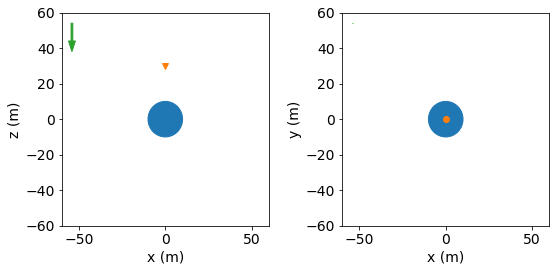

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plt_limits = 2*np.max(np.abs([target_radius, rx_x, rx_y, rx_z]))*np.r_[-1, 1]

for a, title in zip(ax, ["cross_section", "depth_slice"]):
    circle = plt.Circle([0.,0.], target_radius, color='C0')
    a.add_artist(circle)
    a.set_xlim(plt_limits)
    a.set_ylim(plt_limits)
    
# cross section
ax[0].plot(rx_x, rx_z, 'v', color="C1")
ax[0].arrow(
    0.9*plt_limits[0], 0.9*plt_limits[1], 10*B0_unit_direction[0], 10*B0_unit_direction[2], 
    width=1, head_width=4, color="C2"
)
ax[0].set_xlabel("x (m)")
ax[0].set_ylabel("z (m)")

# cross section
ax[1].plot(rx_x, rx_y, 'o', color="C1")

ax[1].arrow(
    0.9*plt_limits[0], 0.9*plt_limits[1], 10*B0_unit_direction[0], 10*B0_unit_direction[1], 
    width=1, head_width=0 if np.isclose(B0_unit_direction[0], B0_unit_direction[0]) else 4, color="C2"
)
ax[1].set_xlabel("x (m)")
ax[1].set_ylabel("y (m)")

plt.tight_layout()

### Set up the simulation

For this example, we treat the sphere as a point dipole and compute its moment. The `dipole` object that we create encodes the geometry, and we can use the method `dipole.magnetic_flux_density` to compute tha magnetic flux at the receiver locations. 

In [10]:
# dipole is the sphere
dipole = MagneticDipoleWholeSpace(
    location=np.r_[0., 0., 0.], # center of dipole at origin
    orientation=B0_unit_direction, # dipole is in same direction as Earth's field
    moment=target_permeability * B0_amplitude * target_volume # moment = how strong is the magnet of the dipole?
)

Text(0, 0.5, 'z (m)')

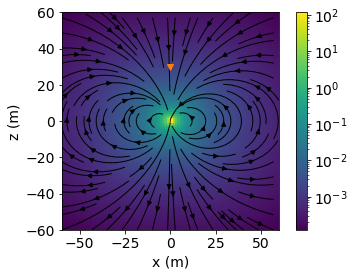

In [11]:
## plot sample magnetic fields

def plot_amplitude(ax, x, y, v):
    v = spatial.vector_magnitude(v)
    plt.colorbar(
        ax.pcolormesh(
            x, y, v.reshape(len(x), len(y), order='F'), norm=LogNorm()
        ), ax=ax
    )
    ax.axis('square')


# plot streamlines
def plot_streamlines(ax, x, y, vx, vy):
    vx = vx.reshape(len(x), len(y), order='F')
    vy = vy.reshape(len(x), len(y), order='F')
    ax.streamplot(x, y, vx.T, vy.T, color='k', linewidth=1)
    
# define the plotting code
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plt_limits = 2*np.max(np.abs([target_radius, rx_x, rx_y, rx_z]))*np.r_[-1, 1]
x = np.linspace(plt_limits[0], plt_limits[1], 100)

# cross section at center of dipole
b_cross_section = dipole.magnetic_flux_density(xyz=utils.ndgrid([x, np.r_[0], x]))
plot_amplitude(ax, x, x, b_cross_section)
plot_streamlines(ax, x, x, b_cross_section[:, 0], b_cross_section[:, 2])
ax.plot(rx_x, rx_z, 'v', color="C1")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")



## Generate data set

The following function generates a data set given a list or numpy array of each of the input parameters

In [12]:
def generate_dipole_data(
    B0_declination,
    B0_inclination,
    B0_amplitude,
    target_radius,  
    target_permeability,
    rx_x,
    rx_y,
    rx_z, 
    data_type="TMI"  # Can be 'x', 'y', 'z' (which returns the component of the magnetic field) or 'TMI' (the projection on the inducing field)
):
    """
    Given all of the parameters to describe the setup, we produce a numpy array of data. In order, 
    the columns are
    
    - data[:, 0] : B0_declination
    - data[:, 1] : B0_inclination
    - data[:, 2] : B0_amplitude
    - data[:, 3] : target_radius
    - data[:, 4] : target_permeability
    - data[:, 5] : rx_x
    - data[:, 6] : rx_y
    - data[:, 7] : rx_z
    - data[:, 8] : dobs   
    
    This function returns both the d
    
    """
    
    # Initialize data storage
    nD = (
        len(B0_declination) * len(B0_inclination) * len(B0_amplitude) *
        len(target_radius) * len(target_permeability) *
        len(rx_x) * len(rx_y) * len(rx_z)
    )
    data_header = [
        "B0_declination", "B0_inclination", "B0_amplitude", 
        "target_radius", "target_permeability",
        "rx_x", "rx_y", "rx_z", "dobs"
    ]
    
    data = []
    xyz = utils.ndgrid([rx_x, rx_y, rx_z])
    
    # Loop over parameters to evaluate data
    # inducing field
    for b0d in B0_declination:  
        for b0i in B0_inclination:
            for b0a in B0_amplitude:
                
                B0_unit_direction = inclination_declination_to_cartesian(b0i, b0d)
                B0 = b0a * B0_unit_direction
                
                # target properties
                for r in target_radius:
                    for mur in target_permeability:
                        
                        # initialize an empty array to store the data
                        tmp_data = np.zeros((xyz.shape[0], len(data_header)))
                        
                        # populate data with parameters
                        tmp_data[:, 0] = b0d
                        tmp_data[:, 1] = b0i
                        tmp_data[:, 2] = b0a
                        tmp_data[:, 3] = r
                        tmp_data[:, 4] = mur
                        tmp_data[:, 5:8] = xyz
                        
                        # compute the observed data
                        target_volume = 4/3 * np.pi * r **3
                        target_moment = mur * b0a * target_volume 
                        
                        # create the dipole object
                        dipole = MagneticDipoleWholeSpace(
                            location=np.r_[0., 0., 0.], 
                            orientation=B0_unit_direction,
                            moment=target_moment
                        )
                        
                        # evaluate the data
                        b_vector = dipole.magnetic_flux_density(xyz)
                        if data_type.lower() == "tmi":
                            dobs = spatial.vector_dot(
                                b_vector, B0_unit_direction
                            )
                        elif data_type.lower() == "x":
                            dobs = b_vector[:, 0]
                        elif data_type.lower() == "y":
                            dobs = b_vector[:, 1]
                        elif data_type.lower() == "z":
                            dobs = b_vector[:, 2]
                        else:
                            raise Exception("data_type must be in ['tmi', 'x', 'y', 'z']")
                        
                        tmp_data[:, 8] = dobs
                        
                        data.append(tmp_data)
    
    # stack up the data so we return a single numpy array
    data = np.vstack(data)
    return data_header, data

### select parameters

In [13]:
# describe the inducing field
B0_declination = np.r_[0., 45.]  # degrees
B0_inclination = np.r_[45, 90.]  # degrees 
B0_amplitude = np.r_[56000] # amplitude in nT (56000 nT)

# describe the target
target_radius = np.r_[5, 10]
target_permeability = np.r_[2, 5]  # relative permeability of the target

# receiver locations
rx_x = np.linspace(-40, 40, 15)  # generate 15 equally spaced data points between -40 and 40 (x-axis)
rx_y = np.linspace(-40, 40, 15)
rx_z = np.r_[20]

nD = (
    len(B0_declination) * len(B0_inclination) * len(B0_amplitude) *
    len(target_radius) * len(target_permeability) *
    len(rx_x) * len(rx_y) * len(rx_z)
)
print(f"Number of data: {nD:1.2e}")

Number of data: 3.60e+03


### compute the data

In [14]:
data_header, data = generate_dipole_data(
    B0_declination=B0_declination,
    B0_inclination=B0_inclination,
    B0_amplitude=B0_amplitude,
    target_radius=target_radius,  
    target_permeability=target_permeability,
    rx_x=rx_x,
    rx_y=rx_y,
    rx_z=rx_z, 
    data_type="TMI"
)

In [16]:
data

array([[ 0.00000000e+00,  4.50000000e+01,  5.60000000e+04, ...,
        -4.00000000e+01,  2.00000000e+01,  1.35747831e-05],
       [ 0.00000000e+00,  4.50000000e+01,  5.60000000e+04, ...,
        -4.00000000e+01,  2.00000000e+01,  2.29569021e-05],
       [ 0.00000000e+00,  4.50000000e+01,  5.60000000e+04, ...,
        -4.00000000e+01,  2.00000000e+01,  3.59953793e-05],
       ...,
       [ 4.50000000e+01,  9.00000000e+01,  5.60000000e+04, ...,
         4.00000000e+01,  2.00000000e+01, -4.50368727e-04],
       [ 4.50000000e+01,  9.00000000e+01,  5.60000000e+04, ...,
         4.00000000e+01,  2.00000000e+01, -4.07748279e-04],
       [ 4.50000000e+01,  9.00000000e+01,  5.60000000e+04, ...,
         4.00000000e+01,  2.00000000e+01, -3.61994215e-04]])

### Plot the data

In the below cell, I plot the magnetic field measurements for each receiver location in a given setup (e.g. one example of the 

In [17]:
nd_per_simulation = len(rx_x) * len(rx_y) * len(rx_z)

def plot_data(simulation_ind, yline):
    data_to_plot = data[nd_per_simulation*simulation_ind: nd_per_simulation*(simulation_ind + 1), :]
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    cb = plt.colorbar(ax[0].scatter(
        data_to_plot[:, 5], 
        data_to_plot[:, 6],
        c=data_to_plot[:, 8]
    ), ax=ax[0])
    ax[0].set_aspect(1)

    ax[0].set_xlabel("x (m)")
    ax[0].set_ylabel("y (m)")
    cb.set_label("B (nT)")
    
    # show info in title
    ax[1].set_title(
        f"inclination: {data_to_plot[0, 0]} \n"
        f"declination: {data_to_plot[0, 1]} \n"
        f"radius: {data_to_plot[0, 3]} \n"
        f"rel. permeability: {data_to_plot[0, 4]} \n"
    )

    # line plot
    inds = slice(yline*len(rx_x), len(rx_x) * (yline+1))
    ax[0].plot(data_to_plot[inds, 5], data_to_plot[inds, 6], 'k', lw=0.5)
    x_plot = data_to_plot[inds, 5]
    d_plot = data_to_plot[inds, 8]
    ax[1].plot(x_plot, d_plot, 'o')
    ax[1].grid("k", lw=0.5, alpha=0.5)
    ax[1].set_xlabel("x (m)")
    ax[1].set_ylabel("B (nT)")
    
    

    plt.tight_layout()

ipywidgets.interactive(
    plot_data, 
    simulation_ind=ipywidgets.IntSlider(min=0, max=data.shape[0]/nd_per_simulation),
    yline=ipywidgets.IntSlider(min=0, max=len(rx_y))
)

interactive(children=(IntSlider(value=0, description='simulation_ind', max=16), IntSlider(value=0, description…